In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.transforms as mtransforms
import matplotlib

from matplotlib import ticker
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from os import path
from scipy import stats

blues = sns.color_palette('Blues_r')
purples = sns.color_palette('Purples_r')
greens = sns.color_palette('Greens_r')
greys = sns.color_palette('Greys')

plt.style.use('style.mpl')

# Load all the data and metadata
Used to generate all figures

In [2]:
# Load lifetime data manifest - all data already blanked to min intensity. 
lifetime_manifest = pd.read_csv('../data/lifetime/061322/manifest.csv', index_col=0)
lifetime_manifest.head()

,sensor,sensor_conc,quencher,quencher_ul,quencher_conc_uM,raw_filename,csv_filename,lambda_ex_nm,lambda_em_nm
0,RTDP,40 uM,PYO,0,0.00,RTDP.2_alone_1.ns1,RTDP+0ulPYO.csv,355,650
1,RTDP,40 uM,PYO,2,7.49,RTDP.2_+2ulPYO_0.ns1,RTDP+2ulPYO.csv,355,650
2,RTDP,40 uM,PYO,20,74.26,RTDP.2_+20ulPYO_0.ns1,RTDP+20ulPYO.csv,355,650
3,RTDP,40 uM,PYO,40,147.06,RTDP.2_+40ulPYO_0.ns1,RTDP+40ulPYO.csv,355,650
4,RTDP,40 uM,PYO,60,218.45,RTDP.2_+60ulPYO_0.ns1,RTDP+60ulPYO.csv,355,650


In [3]:
# Load in-vitro measurements by serial dilution. 
# These data were pre-processed by 00-05 notebooks.

# RTDP supernatant data
pre_rtdp_vitro = pd.read_csv("../data/RTDP_vitro/mean_rtdp_fluor_pre.csv")
post_rtdp_vitro = pd.read_csv("../data/RTDP_vitro/mean_rtdp_fluor_post.csv")

# Fits of K_SV from RTDP data
rtdp_fits_vitro = pd.read_csv("../data/RTDP_vitro/fits.csv", index_col=0).set_index('name')

# O2NS in-vitro data
pre_o2ns_vitro = pd.read_csv("../data/O2NS_vitro/mean_O2NS_fluor_pre.csv")
post_o2ns_vitro = pd.read_csv("../data/O2NS_vitro/mean_O2NS_fluor_post.csv")

# Fits of K_SV from OS2NS data
o2ns_fits_vitro = pd.read_csv("../data/O2NS_vitro/fits.csv", index_col=0).set_index('name')

In [4]:
# Load measurements of supernatant quenching by serial dilution. 

# RTDP supes
pre_rtdp_supes = pd.read_csv("../data/RTDP_supes/RTDP_long_df_pre_processed.csv", index_col=0)
post_rtdp_supes = pd.read_csv("../data/RTDP_supes/RTDP_long_df_post_processed.csv", index_col=0)
rtdp_fits_mm_supes = pd.read_csv("../data/RTDP_supes/fits.csv", index_col=0).set_index('name')

# O2NS supes
pre_o2ns_supes = pd.read_csv("../data/O2NS_supes/O2NS_long_df_pre_processed.csv", index_col=0)
post_o2ns_supes = pd.read_csv("../data/O2NS_supes/O2NS_long_df_post_processed.csv", index_col=0)
o2ns_fits_mm_supes = pd.read_csv("../data/O2NS_supes/fits.csv", index_col=0).set_index('name')

# RTDP isolates
pre_rtdp_isolates = pd.read_csv("../data/RTDP_isolate_supes/RTDP_long_df_pre_processed.csv", index_col=0)
post_rtdp_isolates = pd.read_csv("../data/RTDP_isolate_supes/RTDP_long_df_post_processed.csv", index_col=0)
rtdp_isolate_fits_mm = pd.read_csv("../data/RTDP_isolate_supes/fits.csv", index_col=0).set_index('name')

# O2NS supes
pre_o2ns_isolates = pd.read_csv("../data/O2NS_isolate_supes/O2NS_long_df_pre_processed.csv", index_col=0)
post_o2ns_isolates = pd.read_csv("../data/O2NS_isolate_supes/O2NS_long_df_post_processed.csv", index_col=0)
o2ns_isolate_fits_mm = pd.read_csv("../data/O2NS_isolate_supes/fits.csv", index_col=0).set_index('name')


In [5]:
# The name code ('short_name') is the index column
names_df = pd.read_csv('../isolates/short_names.csv', index_col=0)
strain_name_mapping = dict((sn, row.title) for sn,row in names_df.iterrows())
short_name_mapping = dict((sn, row.short_title) for sn,row in names_df.iterrows())

# Set up color mapping for plotting. 
all_strains = ['PA14 WT', 'PA14 dphz', 'EC WT', 'BG', 'PS', 'CG', 'CS', 'MM4', 'AGG', 'PO']
isolates_plot_order = ['PA14 WT', 'EC WT', 'BG', 'PS', 'CG', 'CS', 'MM4', 'AGG', 'PO']
n_colors = len(all_strains)
pal = sns.diverging_palette(200, 50, l=65, center="dark", n=len(all_strains))

markers = 'o,v,^,d'.split(',')
strain_color_mapping = dict(zip(all_strains, pal))
strain_name_mapping

{'PA14 WT': '$\\it{P. aeruginosa}$ PA14',
 'PA14 dphz': 'PA14 $\\Delta$phz',
 'PA14 dside': 'PA14 $\\Delta$sid',
 'PA14 dphz dside': 'PA14 $\\Delta$phz $\\Delta$sid',
 'EC WT': '$\\it{E. coli}$',
 'BG': '$\\it{B. glumae}$',
 'BP': '$\\it{B. pumilus}$',
 'CG': '$\\it{C. ginsengisegetis}$',
 'CS': '$\\it{C. shigense}$',
 'MM4': '$\\it{Streptomyces}$ sp. MM21',
 'SP': '$\\it{S. phaeochromogenes}$',
 'AG': '$\\it{A. agilis}$',
 'PP': '$\\it{P. phenanthrenivorans}$',
 'PK': '$\\it{P. kyongii}$',
 'AGG': '$\\it{P. agglomerans}$',
 'PO': '$\\it{P. orientalis}$',
 'PS': '$\\it{P. synxantha}$'}

# Figure 1
Figure 1 has 3 rows. 
* Top row is supernatant observations with PA14 and E. coli.
* Middle row is lifetime spectroscopy with PYO and 3 sensors.
* Bottom row is dilution-based quenching constants of pure molecules.
I will make each of these rows separately since it was too much of a pain to compose the whole figure in matplotlib. 

I will also make the relevant supplementary figures as I go. 

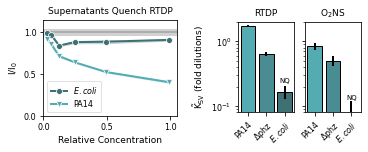

In [6]:
# Top row of the publication figure
fig = plt.figure(figsize=(5, 2), constrained_layout=True)
subfigs = fig.subfigures(ncols=2, wspace=0.05)
right_axs = subfigs[1].subplots(ncols=2, sharey=True)

# LEFTMOST PANEL in LEFT SUBFIGURE
# Strains + RTDP in minimal media
left_ax = subfigs[0].subplots()
left_ax.axhline(1.0, color=greys[2])

names2plot = 'EC WT,PA14 WT'.split(',')
means = post_rtdp_supes.groupby('name').mean()
stds = post_rtdp_supes.groupby('name').std()
cv_rtdp_dye_alone = (stds.loc['RTDP', 'blanked_rtdp_fluor'] / 
                     means.loc['RTDP', 'blanked_rtdp_fluor'])
left_ax.axhspan(1.0 - cv_rtdp_dye_alone, 1.0 + cv_rtdp_dye_alone, color=greys[1])

for i, n in enumerate(names2plot):
    my_df = post_rtdp_supes[post_rtdp_supes.name == n]
    label = names_df.loc[n].short_title
    sns.lineplot(data=my_df, x='concentration', y='F_F0_ratio',
                 color=strain_color_mapping[n], marker=markers[i], 
                 markersize=6, markeredgecolor='w', label=label,
                 ax=left_ax)


left_ax.legend(ncol=1, loc=3, framealpha=0.6, fontsize=8)
left_ax.set_title('Supernatants Quench RTDP')
left_ax.set_xticks(np.arange(0, 1.1, 0.5))
left_ax.set_yticks(np.arange(0, 1.1, 0.5))
left_ax.set_ylim(0, 1.15)
left_ax.set_xlim(0, 1.05)
left_ax.set_xlabel('Relative Concentration')
left_ax.set_ylabel('$I/I_0$')

# MIDDLE PANEL in RIGHT SUBFIGURE
# effective KSV for RTDP supes
my_ax = right_axs[0]
my_ax.set_yscale('log')

plot_order = 'PA14 WT,PA14 dphz,EC WT'.split(',')
xs = np.arange(len(plot_order))

# Arrange data for RTDP quemching constants
ys = rtdp_fits_mm_supes.loc[plot_order]['K_SV'].values
yerr = rtdp_fits_mm_supes.loc[plot_order]['K_SV err']
colors = [strain_color_mapping[k] for k in plot_order]

bars_rtdp = my_ax.bar(xs, ys, yerr=yerr, edgecolor='k',
                      lw=1, ecolor='k', color=colors)
my_ax.text(2, 0.23, 'NQ', ha='center', fontsize=7)
my_ax.set_title('RTDP')
my_ax.set_ylabel('$\\tilde{K}_{SV}$ (fold dilutions)', fontsize=9)
my_ax.set_ylim(0.08, 2)
        
# RIGHTMOST PANEL in RIGHT SUBFIGURE
# Barplot of effective KSV values for O2NS
my_ax = right_axs[1]
my_ax.set_yscale('log')

# Arrange data for O2NS quenching constants
# set y-values to 0 for those we decided were not quenchers.
ys = o2ns_fits_mm_supes.loc[plot_order]['K_SV'].values
yerr = o2ns_fits_mm_supes.loc[plot_order]['K_SV err']

bars_o2ns = my_ax.bar(xs, ys, yerr=yerr, edgecolor='k',
                      lw=1, ecolor='k', color=colors)

my_ax.text(2, 0.125, 'NQ', ha='center', fontsize=7)
my_ax.set_title('O$_2$NS')

for ax in right_axs:
    xticks = [short_name_mapping[n] for n in plot_order]
    ax.set_xticks(np.arange(len(plot_order)))
    ax.set_xticklabels(xticks, rotation=45, ha='right', rotation_mode='anchor')

plt.savefig('../figures/fig1_top_row.png', dpi=600, facecolor='w')
plt.show()

/var/folders/h9/fvnb4xnn63qg71jx6ncvg62w0000gn/T/ipykernel_1863/89412547.py:72: MatplotlibDeprecationWarning: The remove function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  my_ax.get_shared_y_axes().remove(my_ax)
/var/folders/h9/fvnb4xnn63qg71jx6ncvg62w0000gn/T/ipykernel_1863/89412547.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


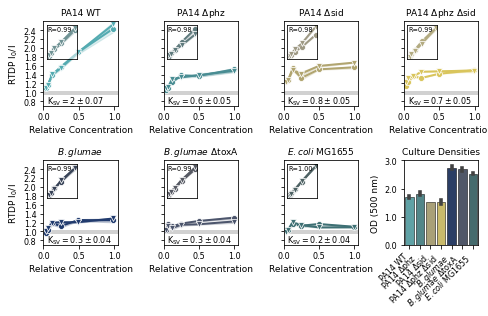

In [7]:
# Figure 1S1 - RTDP quenching traces from GMM exp. 
fig, axs = plt.subplots(figsize=(6.875, 4.5), nrows=2, ncols=4,
                        sharex=False, sharey='row')

plot_order = [
    'PA14 WT', 'PA14 dphz', 'PA14 dside', 'PA14 dphz dside', 
    'BG WT', 'BG dtox', 'EC WT']
si_label_mapping = {
    'PA14 WT': 'PA14 WT',
    'PA14 dphz': 'PA14 $\Delta$phz',
    'PA14 dside': 'PA14 $\Delta$sid', 
    'PA14 dphz dside': 'PA14 $\Delta$phz $\Delta$sid',
    'EC WT': '$\it{E. coli}$ MG1655',
    'BG WT': '$\it{B. glumae}$',
    'BG dtox': '$\it{B. glumae}$ $\Delta$toxA',
}

bg_pal = sns.color_palette('cividis')
colors = [strain_color_mapping.get(n) for n in plot_order]
si_color_mapping = strain_color_mapping.copy()
si_color_mapping['PA14 dside'] = bg_pal[-2]
si_color_mapping['PA14 dphz dside'] = bg_pal[-1]
si_color_mapping['BG WT'] = bg_pal[0]
si_color_mapping['BG dtox'] = bg_pal[1]

means = post_rtdp_supes.groupby('name').mean()
stds = post_rtdp_supes.groupby('name').std()
cv_rtdp_dye_alone = (stds.loc['RTDP', 'blanked_rtdp_fluor'] / 
                     means.loc['RTDP', 'blanked_rtdp_fluor'])
my_markers = markers[:2]

# RTDP traces
for ax, n in zip(axs.flatten(), plot_order):
    ax.axhspan(1.0 - cv_rtdp_dye_alone, 1.0 + cv_rtdp_dye_alone, color=greys[1])
    
    my_df = post_rtdp_supes[post_rtdp_supes.name == n]
    sns.lineplot(data=my_df, x='concentration', y='F0_F_ratio',
                 style='replicate', dashes=False,
                 color=si_color_mapping[n], markers=my_markers, 
                 markersize=6, markeredgecolor='w', ax=ax, legend=False)

    fit_ksv = rtdp_fits_mm_supes.loc[n]
    ksv_str = '$K_{{SV}} = {0:0.1g} \pm {1:0.1g}$'.format(
        fit_ksv['K_SV'], fit_ksv['K_SV err'])
    ax.set_title(si_label_mapping[n])
    ax.set_xticks(np.arange(0, 1.1, 0.5))
    ax.set_yticks(np.arange(0.6, 2.6, 0.2))
    ax.set_ylim(0.7, 2.6)
    ax.set_xlim(0, 1.05)
    ax.set_xlabel('Relative Concentration')
    ax.set_ylabel('RTDP $I_0/I$')
    ax.text(0.05, 0.75, ksv_str, fontsize=8)
    
    # Inset axes show the fluorescence before RTDP addition
    axins = inset_axes(ax, width="40%", height="40%", loc=2)
    axins.patch.set_alpha(0.5)
    my_df = pre_rtdp_supes[pre_rtdp_supes.name == n]
    res = stats.pearsonr(my_df.concentration, my_df.blanked_rtdp_fluor)
    sns.lineplot(data=my_df, x='concentration', y='blanked_rtdp_fluor',
                 style='replicate', dashes=False,
                 color=sns.desaturate(si_color_mapping[n], 0.4),
                 markers=my_markers, markersize=6, markeredgecolor='w',
                 ax=axins, legend=False)
    axins.set_xlabel('')
    axins.set_ylabel('')
    axins.set_xticks([])
    axins.set_yticks([])
    axins.text(0.02, 0.8, 'R={0:.2f}'.format(res[0]), fontsize=6.5, transform=axins.transAxes)
    
od_df = pd.read_csv('../data/RTDP_supes/120321_ODs.csv')
my_ax = axs[1, -1]
my_ax.get_shared_y_axes().remove(my_ax)

# Create and assign new ticker
my_ax.yaxis.major = matplotlib.axis.Ticker()
# The new ticker needs new locator and formatters
my_ax.yaxis.set_major_locator(ticker.AutoLocator())
my_ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

labels = [si_label_mapping[n] for n in plot_order]
colors = [si_color_mapping[n] for n in plot_order]

sns.barplot(data=od_df, x='strain', y='OD500', ax=my_ax,
            order=plot_order, palette=colors, lw=0.5, edgecolor='k')
my_ax.set_xticklabels(labels, ha='right', rotation=45)
my_ax.set_xlabel('')
my_ax.set_ylabel('OD (500 nm)')
my_ax.set_title('Culture Densities')
my_ax.set_ylim(0, 3)
my_ax.set_yticks(np.arange(0, 3.1, 1.0))
my_ax.set_yticklabels(np.arange(0, 3.1, 1.0))
plt.setp(my_ax.get_yticklabels(), visible=True)
my_ax.yaxis.set_tick_params(which='both', labelbottom=True)

plt.tight_layout()
plt.savefig('../figures/figS2_rtdp_traces.png', dpi=600, facecolor='w')
plt.savefig('../figures/figS2_rtdp_traces.pdf', dpi=300, facecolor='w')

plt.show()

/var/folders/h9/fvnb4xnn63qg71jx6ncvg62w0000gn/T/ipykernel_1863/589808373.py:48: MatplotlibDeprecationWarning: The remove function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  my_ax.get_shared_y_axes().remove(my_ax)
/var/folders/h9/fvnb4xnn63qg71jx6ncvg62w0000gn/T/ipykernel_1863/589808373.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


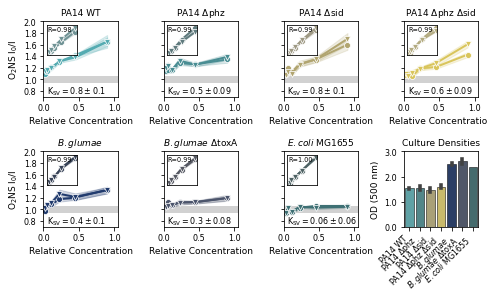

In [8]:
# Figure 1S1 - O2NS quenching traces. 
fig, axs = plt.subplots(figsize=(6.875, 4.25), nrows=2, ncols=4,
                        sharex=False, sharey='row')
    
# O2NS traces
means = post_o2ns_supes.groupby('name').mean()
stds = post_o2ns_supes.groupby('name').std()
cv_pt_dye_alone = (stds.loc['O2NS', 'blanked_pt_fluor'] / 
                     means.loc['O2NS', 'blanked_pt_fluor'])
for ax, n in zip(axs.flatten(), plot_order):
    ax.axhspan(1.0 - cv_pt_dye_alone, 1.0 + cv_pt_dye_alone, color=greys[1])
    my_df = post_o2ns_supes[post_o2ns_supes.name == n]
    sns.lineplot(data=my_df, x='concentration', y='F0_F_ratio',
                 style='replicate', dashes=False,
                 color=si_color_mapping[n], markers=my_markers, 
                 markersize=6, markeredgecolor='w', ax=ax, legend=False)

    fit_ksv = o2ns_fits_mm_supes.loc[n]
    ksv_str = '$K_{{SV}} = {0:0.1g} \pm {1:0.1g}$'.format(
        fit_ksv['K_SV'], fit_ksv['K_SV err'])
    ax.set_title(si_label_mapping[n])
    ax.set_xticks(np.arange(0, 1.1, 0.5))
    ax.set_yticks(np.arange(0.6, 2.1, 0.2))
    ax.set_ylim(0.7, 2.0)
    ax.set_xlim(0, 1.05)
    ax.set_xlabel('Relative Concentration')
    ax.set_ylabel('$O_2NS$ $I_0/I$')
    ax.text(0.05, 0.75, ksv_str, fontsize=8)
    
    # Inset axes show the fluorescence before O2NS addition
    axins = inset_axes(ax, width="40%", height="40%", loc=2)
    axins.patch.set_alpha(0.5)
    my_df = pre_o2ns_supes[pre_o2ns_supes.name == n]
    res = stats.pearsonr(my_df.concentration, my_df.blanked_pt_fluor)
    sns.lineplot(data=my_df, x='concentration', y='blanked_pt_fluor',
                 style='replicate', dashes=False,
                 color=sns.desaturate(si_color_mapping[n], 0.4),
                 markers=my_markers, markersize=6, markeredgecolor='w',
                 ax=axins, legend=False)
    axins.set_xlabel('')
    axins.set_ylabel('')
    axins.set_xticks([])
    axins.set_yticks([])
    axins.text(0.02, 0.8, 'R={0:.2f}'.format(res[0]), fontsize=6.5, transform=axins.transAxes)
    
od_df = pd.read_csv('../data/O2NS_supes/100621_ODs.csv')
my_ax = axs[1, -1]
my_ax.get_shared_y_axes().remove(my_ax)

# Create and assign new ticker
my_ax.yaxis.major = matplotlib.axis.Ticker()
# The new ticker needs new locator and formatters
my_ax.yaxis.set_major_locator(ticker.AutoLocator())
my_ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

labels = [si_label_mapping[n] for n in plot_order]
colors = [si_color_mapping[n] for n in plot_order]

sns.barplot(data=od_df, x='strain', y='OD500', ax=my_ax,
            order=plot_order, palette=colors, lw=0.5, edgecolor='k')
my_ax.set_xticklabels(labels, ha='right', rotation=45)
my_ax.set_xlabel('')
my_ax.set_ylabel('OD (500 nm)')
my_ax.set_title('Culture Densities')
my_ax.set_ylim(0, 3)
my_ax.set_yticks(np.arange(0, 3.1, 1.0))
my_ax.set_yticklabels(np.arange(0, 3.1, 1.0))
plt.setp(my_ax.get_yticklabels(), visible=True)
my_ax.yaxis.set_tick_params(which='both', labelbottom=True)

plt.tight_layout()    
plt.savefig('../figures/figS3_O2NS_traces.png', dpi=600, facecolor='w')
plt.savefig('../figures/figS3_O2NS_traces.pdf', dpi=300, facecolor='w')

plt.show()

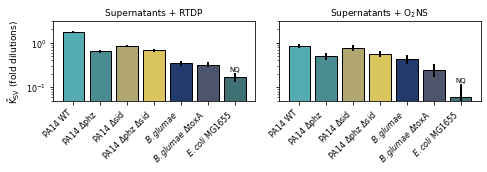

In [9]:
# SI figure showing inferred K_SV values for culture supes. 
fig, axs = plt.subplots(figsize=(6.875, 2.5), nrows=1, ncols=2, sharey=True)
axs[0].set_yscale('log')

xticks = np.arange(len(plot_order))
labels = [si_label_mapping[n] for n in plot_order]
colors = [si_color_mapping[n] for n in plot_order]

xs = np.arange(len(plot_order))
ys = rtdp_fits_mm_supes.loc[plot_order]['K_SV'].values
yerr = rtdp_fits_mm_supes.loc[plot_order]['K_SV err']
axs[0].bar(xs, ys, yerr=yerr, edgecolor='k',
           lw=1, ecolor='k', color=colors)
axs[0].set_title('Supernatants + RTDP')
axs[0].set_ylabel('$\\tilde{K}_{SV}$ (fold dilutions)', fontsize=9)
axs[0].set_xticks(xticks)
axs[0].set_xticklabels(labels, rotation=45, ha='right')
axs[0].set_ylim(0.05, 3)

# Annotate non-quenchers
for i, name in enumerate(plot_order):
    q = rtdp_fits_mm_supes.loc[name].quencher
    yval = max(ys[i] + yerr[i], 0.08)
    if not q:
        axs[0].text(i, 1.1*yval, 'NQ', ha='center', fontsize=7)

ys = o2ns_fits_mm_supes.loc[plot_order]['K_SV'].values
yerr = o2ns_fits_mm_supes.loc[plot_order]['K_SV err']
axs[1].bar(xs, ys, yerr=yerr, edgecolor='k',
           lw=1, ecolor='k', color=colors)
axs[1].set_title('Supernatants + O$_2$NS')
axs[1].set_xticks(xticks)
axs[1].set_xticklabels(labels, rotation=45, ha='right')

# Annotate non-quenchers
for i, name in enumerate(plot_order):
    q = o2ns_fits_mm_supes.loc[name].quencher
    yval = max(ys[i] + yerr[i], 0.08)
    if not q:
        axs[1].text(i, 1.1*yval, 'NQ', ha='center', fontsize=7)
        
plt.tight_layout()
plt.savefig('../figures/figS4_all_supe_Ksv.png', dpi=600, facecolor='w')
plt.savefig('../figures/figS4_all_supe_Ksv.pdf', dpi=300, facecolor='w')
plt.show()

In [10]:
# Helper to plot a lifetime trace on an axis
def plot_lifetime_data(ax, sensor_name, color_palette, quencher_ul_to_plot=(0,20,60)):
    qul2plot = quencher_ul_to_plot
    pal = color_palette
    
    mask = lifetime_manifest.sensor == sensor_name
    mask = np.logical_and(mask, lifetime_manifest.quencher_ul.isin(qul2plot))
    sub_df = lifetime_manifest[mask]

    for i, (idx, row) in enumerate(sub_df.iterrows()):
        label = row.sensor
        if row.quencher_ul > 0:
            label = '+{0} $\mu M$ PYO'.format(round(row.quencher_conc_uM))
        lt_data = pd.read_csv(path.join('../data/lifetime/061322/', row.csv_filename))
        time_us = lt_data.time_s*1e6
        normed_intensity = lt_data.intensity / lt_data.intensity.max()
        ax.plot(time_us, normed_intensity, color=pal[i], label=label)
        
    ax.set_xlabel('time ($\mu s$)')    
    ax.set_ylabel('$I / I_{max}$')
    ax.legend(fontsize=6)


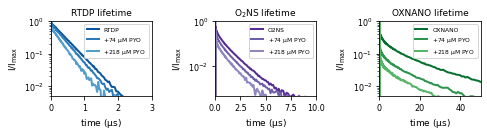

In [11]:
# middle row of the publication figure - lifetime data
fig, axs = plt.subplots(figsize=(6.875, 2), ncols=3)

# Plot the lifetime data - RTDP, O2NS and then OXNANO
my_ax = axs[0]
my_ax.set_yscale('log')
plot_lifetime_data(my_ax, 'RTDP', blues)
my_ax.set_ylim(5e-3, 1)
my_ax.set_xlim(0, 3)
my_ax.set_title('RTDP lifetime')

my_ax = axs[1]
my_ax.set_yscale('log')
plot_lifetime_data(my_ax, 'O2NS', purples)
my_ax.set_ylim(5e-4, 1)
my_ax.set_xlim(0, 10)
my_ax.set_title('O$_2$NS lifetime')

my_ax = axs[2]
my_ax.set_yscale('log')
plot_lifetime_data(my_ax, 'OXNANO', greens)
my_ax.set_ylim(5e-3, 1)
my_ax.set_xlim(0, 50)
my_ax.set_title('OXNANO lifetime')


plt.tight_layout()
plt.savefig('../figures/fig1_middle_row.png', dpi=600, facecolor='w')
plt.show()

In [12]:
# Set up color mapping for plotting in-vitro data.
# We will assign a color to every molecule with a KSV > 100 /M w.r.t RTDP.
n_colors_vitro = (rtdp_fits_vitro['K_SV (/M)'] > 500).sum()
pal = sns.color_palette('icefire', n_colors=n_colors_vitro)
greys = sns.color_palette('Greys')

# Sort the RTDP fits in-plate so that they are descending order by K_SV
rtdp_fits_vitro.sort_values('K_SV (/M)', ascending=False, inplace=True)

vitro_plot_order = rtdp_fits_vitro.index.values
n_remaining_colors = rtdp_fits_vitro.index.size - n_colors + 1
vitro_color_mapping = dict(zip(vitro_plot_order, pal + [greys[2]]*(n_remaining_colors)))

vitro_name_mapping = {
    '4-AMINO-SAL': '4-amino sal.',
    'ACETATE': 'acetate',
    'AQDS': 'AQDS',
    'CHLORAM': 'chloram.',
    'KANAMY': 'kanamycin',
    'DMSO': 'DMSO',
    'GLUCOSE': 'glucose',
    'GLUTAMATE': 'glutamate',
    'PCA': 'PCA',
    'PMS': 'PMS',
    'PYO': 'PYO',
    'TOXO': 'toxoflavin',
    'NAD+': 'NAD+',
    'FAD': 'FAD',
    'RIBOFLAV': 'riboflavin',
    'TETRACY': 'tetracycline'}

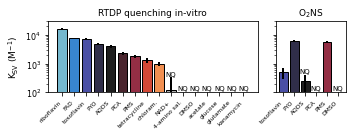

In [13]:
# Bottom row - serial dilution of pure molecules
fig, axs = plt.subplots(figsize=(5, 2), ncols=2,
                        gridspec_kw=dict(width_ratios=[3,1]),
                        sharey=True)

# RTDP fits
plt.sca(axs[0])
plt.yscale('log')

xs = np.arange(len(vitro_plot_order))
ys = rtdp_fits_vitro.loc[vitro_plot_order]['K_SV (/M)'].values
yerr = rtdp_fits_vitro.loc[vitro_plot_order]['K_SV err (/M)']
colors = [vitro_color_mapping[k] for k in vitro_plot_order]

plt.bar(xs, ys, yerr=yerr, edgecolor='k', lw=1, ecolor='k', color=colors)

# Annotate non-quenchers
for i, name in enumerate(vitro_plot_order):
    q = rtdp_fits_vitro.loc[name].quencher
    yval = max(ys[i] + yerr[i], 105)    
    if not q:
        plt.text(i, 1.1*yval, 'NQ', ha='center', fontsize=7)
        
plt.ylim(100, 1e5)
plt.ylabel('$K_{SV}$ (M$^{-1}$)')
plt.title('RTDP quenching in-vitro')

xticks = [vitro_name_mapping[n] for n in vitro_plot_order]
plt.xticks(xs, xticks, rotation=45, ha='right', fontsize=6)

# O2NS fits. 
plt.sca(axs[1])
plt.yscale('log')

o2ns_plot_order = ['TOXO', 'PYO', 'AQDS', 'PCA', 'PMS', 'DMSO']
xs = np.arange(len(o2ns_plot_order))

# set y-values to 0 for those we decided were not quenchers.
ys = o2ns_fits_vitro.loc[o2ns_plot_order]['K_SV (/M)'].values
yerr = o2ns_fits_vitro.loc[o2ns_plot_order]['K_SV err (/M)']
colors = [vitro_color_mapping[k] for k in o2ns_plot_order]

bars_o2ns = plt.bar(xs, ys, yerr=yerr, edgecolor='k',
                    lw=1, ecolor='k', color=colors)

# Annotate non-quenchers
for i, name in enumerate(o2ns_plot_order):
    q = o2ns_fits_vitro.loc[name].quencher
    yval = max(ys[i] + yerr[i], 105)
    if not q:
        plt.text(i, 1.1*yval, 'NQ', ha='center', fontsize=7)

plt.ylim(100, 3e4)
xticks = [vitro_name_mapping[n] for n in o2ns_plot_order]
plt.xticks(xs, xticks, rotation=45, ha='right', fontsize=6)
#plt.ylabel('$K_{SV}$ (M$^{-1}$)')
plt.title('O$_2$NS')
    
plt.tight_layout(w_pad=0.02)
plt.savefig('../figures/fig1_bottom_row.png', dpi=600, facecolor='w')
plt.show()

/var/folders/h9/fvnb4xnn63qg71jx6ncvg62w0000gn/T/ipykernel_1863/677498117.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


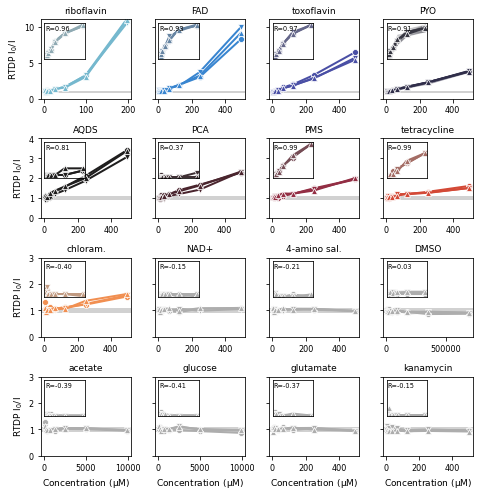

In [14]:
# Figure 1S2 - RTDP quenching with pure molecules 
fig, axs = plt.subplots(figsize=(6.875, 7), nrows=4, ncols=4, sharey='row')

means = post_rtdp_vitro.groupby('name').mean()
stds = post_rtdp_vitro.groupby('name').std()
cv_rtdp_dye_alone = (stds.loc['RTDP', 'blanked_rtdp_fluor'] / 
                     means.loc['RTDP', 'blanked_rtdp_fluor'])

# RTDP traces
for ax, n in zip(axs.flatten(), vitro_plot_order):
    ax.axhspan(1.0 - cv_rtdp_dye_alone, 1.0 + cv_rtdp_dye_alone, color=greys[1])
    my_df = post_rtdp_vitro[post_rtdp_vitro.name == n]
    sns.lineplot(data=my_df, x='concentration', y='F0_F_ratio',
                 style='replicate', dashes=False,
                 color=vitro_color_mapping[n], markers=markers[:3], 
                 markersize=6, markeredgecolor='w', ax=ax, legend=False)

    fit_ksv = rtdp_fits_vitro.loc[n]
    ksv_str = '$K_{{SV}} = {0:0.1g} \pm {1:0.1g}$'.format(
        fit_ksv['K_SV'], fit_ksv['K_SV err'])
    ax.set_title(vitro_name_mapping[n])
    ax.set_ylabel('')
    ax.set_xlabel('')
    
    # Inset axes show the fluorescence before RTDP addition
    axins = inset_axes(ax, width="45%", height="45%", loc=2)
    axins.patch.set_alpha(0.5)
    my_df = pre_rtdp_vitro[pre_rtdp_vitro.name == n]
    res = stats.pearsonr(my_df.concentration, my_df.blanked_rtdp_fluor)
    sns.lineplot(data=my_df, x='concentration', y='blanked_rtdp_fluor',
                 style='replicate', dashes=False,
                 color=sns.desaturate(vitro_color_mapping[n], 0.4),
                 markers=markers[:3], markersize=6, markeredgecolor='w',
                 ax=axins, legend=False)
    axins.set_xlabel('')
    axins.set_ylabel('')
    ymin, ymax = axins.get_ylim()
    if ymax < 5: axins.set_ylim(ymin, 5)
    axins.set_xticks([])
    axins.set_yticks([])
    axins.text(0.02, 0.8, 'R={0:.2f}'.format(res[0]), fontsize=6.5, transform=axins.transAxes)
    
axs[0,0].set_ylim(0, 11)
axs[1,0].set_ylim(0, 4)
axs[2,0].set_ylim(0, 3)
axs[3,0].set_ylim(0, 3)

for ax in axs[-1, :]:
    ax.set_xlabel('Concentration ($\mu M$)')
for ax in axs[:,0]:
    ax.set_ylabel('RTDP $I_0/I$')
    
plt.tight_layout()
plt.savefig('../figures/figS5_RTDP_pure_chem_traces.png', dpi=600, facecolor='w')
plt.savefig('../figures/figS5_RTDP_pure_chem_traces.pdf', dpi=300, facecolor='w')

plt.show()

/var/folders/h9/fvnb4xnn63qg71jx6ncvg62w0000gn/T/ipykernel_1863/2689877514.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


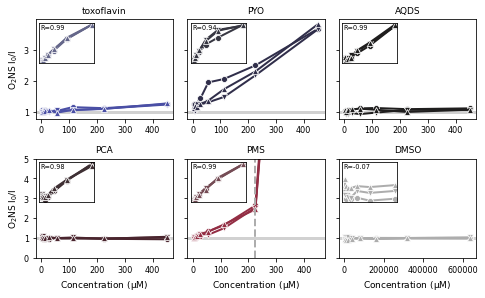

In [15]:
# Figure 1S2 - RTDP quenching with pure molecules 
fig, axs = plt.subplots(figsize=(6.875, 4.25), nrows=2, ncols=3, sharey='row')

means = post_o2ns_vitro.groupby('name').mean()
stds = post_o2ns_vitro.groupby('name').std()
cv_pt_dye_alone = (stds.loc['O2NS', 'blanked_pt_fluor'] / 
                     means.loc['O2NS', 'blanked_pt_fluor'])

# O2NS traces
o2ns_plot_order = ['TOXO', 'PYO', 'AQDS', 'PCA', 'PMS', 'DMSO']
for ax, n in zip(axs.flatten(), o2ns_plot_order):
    ax.axhspan(1.0 - cv_pt_dye_alone, 1.0 + cv_pt_dye_alone, color=greys[1])
    my_df = post_o2ns_vitro[post_o2ns_vitro.name == n]
    sns.lineplot(data=my_df, x='concentration', y='F0_F_ratio',
                 style='replicate', dashes=False,
                 color=vitro_color_mapping[n], markers=markers[:3], 
                 markersize=6, markeredgecolor='w', ax=ax, legend=False)

    fit_ksv = o2ns_fits_vitro.loc[n]
    ksv_str = '$K_{{SV}} = {0:0.1g} \pm {1:0.1g}$'.format(
        fit_ksv['K_SV'], fit_ksv['K_SV err'])
    ax.set_title(vitro_name_mapping[n])
    ax.set_ylabel('')
    ax.set_xlabel('')
    
    # Inset axes show the fluorescence before O2NS addition
    axins = inset_axes(ax, width="40%", height="40%", loc=2)
    axins.patch.set_alpha(0.5)
    my_df = pre_o2ns_vitro[pre_o2ns_vitro.name == n]
    res = stats.pearsonr(my_df.concentration, my_df.blanked_pt_fluor)
    sns.lineplot(data=my_df, x='concentration', y='blanked_pt_fluor',
                 style='replicate', dashes=False,
                 color=sns.desaturate(vitro_color_mapping[n], 0.4),
                 markers=markers[:3], markersize=6, markeredgecolor='w',
                 ax=axins, legend=False)
    axins.set_xlabel('')
    axins.set_ylabel('')
    ymin, ymax = axins.get_ylim()
    if ymax < 5: axins.set_ylim(ymin, 5)
    axins.set_xticks([])
    axins.set_yticks([])
    axins.text(0.02, 0.85, 'R={0:.2f}'.format(res[0]), fontsize=6.5, transform=axins.transAxes)

for ax in axs[-1, :]:
    ax.set_xlabel('Concentration ($\mu M$)')
for ax in axs[:,0]:
    ax.set_ylabel('$O_2NS$ $I_0/I$')

# PMS data skews the lower plots, set the max a little lower.
axs[1,0].set_ylim(0, 5)

# annotate the PMS plot a bit
mask = post_o2ns_vitro.name == 'PMS'
concs = sorted(post_o2ns_vitro[mask].concentration.unique(), reverse=True)
axs[1,1].axvline(concs[1], ls='--', color=greys[2]) 

plt.tight_layout()
plt.savefig('../figures/figS6_O2NS_pure_chem_traces.png', dpi=600, facecolor='w')
plt.savefig('../figures/figS6_O2NS_pure_chem_traces.pdf', dpi=300, facecolor='w')

plt.show()

# Figure 2 
Supernatant assays testing supes. from diverse strains against RTDP and O2NS

In [16]:
o2ns_isolate_fits_mm

,K_SV,K_SV err,R,N_concs,quencher
name,,,,,
AGG,0.430884,0.075596,0.604797,4,True
BG,0.255456,0.068047,0.004407,4,False
CG,0.230028,0.063517,0.413695,4,True
CS,0.390645,0.070330,0.175087,4,False
EC WT,-0.049185,0.056123,0.075255,4,False
MM4,-0.027015,0.053365,-0.168204,4,False
PA14 WT,0.535242,0.089115,0.814426,4,True
PO,0.348957,0.074228,0.904007,4,True
PS,0.362694,0.069370,0.845687,4,True


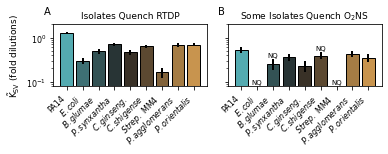

In [17]:
fig, axs = plt.subplots(figsize=(5.5, 2.25), ncols=2, sharey=True)

# Panel A - effective KSV for RTDP isolate supes
plt.sca(axs[0])
plt.yscale('log')

# Arrange data for RTDP quemching constants
xs = np.arange(len(isolates_plot_order))
ys = rtdp_isolate_fits_mm.loc[isolates_plot_order]['K_SV'].values
yerr = rtdp_isolate_fits_mm.loc[isolates_plot_order]['K_SV err']
colors = [strain_color_mapping[k] for k in isolates_plot_order]

# No need to annotate here - all quenched. 
bars_rtdp = plt.bar(xs, ys, yerr=yerr, edgecolor='k',
                    lw=1, ecolor='k', color=colors)
plt.title('Isolates Quench RTDP')
plt.ylabel('$\\tilde{K}_{SV}$ (fold dilutions)', fontsize=9)
        
# Panel B - of effective KSV values for O2NS
plt.sca(axs[1])
plt.yscale('log')

# Arrange data for O2NS quenching constants
# set y-values to 0 for those we decided were not quenchers.
ys = o2ns_isolate_fits_mm.loc[isolates_plot_order]['K_SV'].values
yerr = o2ns_isolate_fits_mm.loc[isolates_plot_order]['K_SV err']
bars_o2ns = plt.bar(xs, ys, yerr=yerr, edgecolor='k',
                    lw=1, ecolor='k', color=colors)

# Annotate non-quenchers
for i, name in enumerate(isolates_plot_order):
    q = o2ns_isolate_fits_mm.loc[name].quencher
    yval = max(ys[i] + yerr[i], 0.08)
    if not q:
        plt.text(i, 1.1*yval, 'NQ', ha='center', fontsize=7)

plt.title('Some Isolates Quench O$_2$NS')
    
for ax in axs:
    plt.sca(ax)
    plt.ylim(0.08, 2)
    xticks = [short_name_mapping[n] for n in isolates_plot_order]
    plt.xticks(np.arange(len(isolates_plot_order)), xticks, fontsize=8,
               rotation=45, ha='right')
    
for label, ax in zip('AB', axs):
    trans = mtransforms.ScaledTranslation(-10/72, 10/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans)
    
plt.tight_layout()
plt.savefig('../figures/fig2.png', dpi=600, facecolor='w')
plt.savefig('../figures/fig2.pdf', dpi=600, facecolor='w')
plt.savefig('../figures/fig2.eps', dpi=600, facecolor='w')
plt.show()

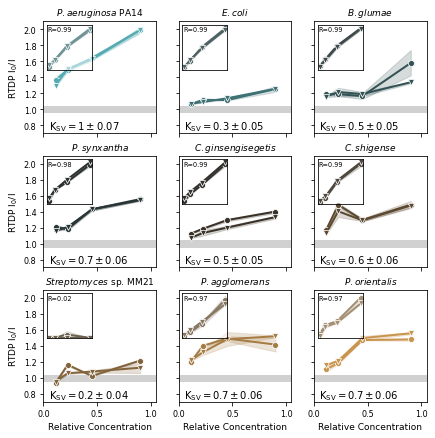

In [18]:
# Figure 2S1 - RTDP quenching traces. 
# Strains + RTDP in minimal media
fig, axs = plt.subplots(figsize=(6.87, 7), nrows=3, ncols=3,
                        sharex='col', sharey='row')

names2plot = 'EC WT,PA14 WT'.split(',')
means = post_rtdp_isolates.groupby('name').mean()
stds = post_rtdp_isolates.groupby('name').std()
cv_rtdp_dye_alone = (stds.loc['RTDP', 'blanked_rtdp_fluor'] / 
                     means.loc['RTDP', 'blanked_rtdp_fluor'])
my_markers = markers[:2]

for ax, n in zip(axs.flatten(), isolates_plot_order):
    ax.axhspan(1.0 - cv_rtdp_dye_alone, 1.0 + cv_rtdp_dye_alone, color=greys[1])
    my_df = post_rtdp_isolates[post_rtdp_isolates.name == n]
    sns.lineplot(data=my_df, x='concentration', y='F0_F_ratio',
                 style='replicate', dashes=False,
                 color=strain_color_mapping[n], markers=my_markers, 
                 markersize=6, markeredgecolor='w', ax=ax, legend=False)

    fit_ksv = rtdp_isolate_fits_mm.loc[n]
    ksv_str = '$K_{{SV}} = {0:0.1g} \pm {1:0.1g}$'.format(
        fit_ksv['K_SV'], fit_ksv['K_SV err'])
    ax.set_title(names_df.loc[n].title)
    ax.set_xticks(np.arange(0, 1.1, 0.5))
    ax.set_yticks(np.arange(0.6, 2.2, 0.2))
    ax.set_ylim(0.7, 2.1)
    ax.set_xlim(0, 1.05)
    ax.set_xlabel('Relative Concentration')
    ax.set_ylabel('RTDP $I_0/I$')
    ax.text(0.05, 0.75, ksv_str)
    
    # Inset axes show the fluorescence before RTDP addition
    axins = inset_axes(ax, width="40%", height="40%", loc=2)
    axins.patch.set_alpha(0.5)
    my_df = pre_rtdp_isolates[pre_rtdp_isolates.name == n]
    res = stats.pearsonr(my_df.concentration, my_df.blanked_rtdp_fluor)
    sns.lineplot(data=my_df, x='concentration', y='blanked_rtdp_fluor',
                 style='replicate', dashes=False,
                 color=sns.desaturate(strain_color_mapping[n], 0.4),
                 markers=my_markers, markersize=6, markeredgecolor='w',
                 ax=axins, legend=False)
    axins.set_xlabel('')
    axins.set_ylabel('')
    ymin, ymax = axins.get_ylim()
    if ymax < 5: axins.set_ylim(ymin, 5)
    axins.set_xticks([])
    axins.set_yticks([])
    axins.text(0.02, 0.85, 'R={0:.2f}'.format(res[0]), fontsize=6.5, transform=axins.transAxes)
    
    
plt.savefig('../figures/figS7_rtdp_traces.png', dpi=600, facecolor='w')
plt.savefig('../figures/figS7_rtdp_traces.pdf', dpi=300, facecolor='w')

plt.show()

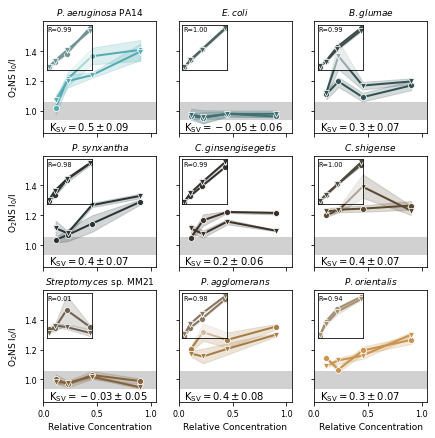

In [19]:
# Figure 2S2 - O2NS quenching traces. 
# Strains + O2NS in minimal media
fig, axs = plt.subplots(figsize=(6.875, 7), nrows=3, ncols=3,
                        sharex='col', sharey='row')

names2plot = 'EC WT,PA14 WT'.split(',')
means = post_o2ns_isolates.groupby('name').mean()
stds = post_o2ns_isolates.groupby('name').std()
cv_pt_dye_alone = (stds.loc['O2NS', 'blanked_pt_fluor'] / 
                     means.loc['O2NS', 'blanked_pt_fluor'])
my_markers = markers[:2]

for ax, n in zip(axs.flatten(), isolates_plot_order):
    ax.axhspan(1.0 - cv_pt_dye_alone, 1.0 + cv_pt_dye_alone, color=greys[1])
    my_df = post_o2ns_isolates[post_o2ns_isolates.name == n]
    sns.lineplot(data=my_df, x='concentration', y='F0_F_ratio',
                 style='replicate', dashes=False,
                 color=strain_color_mapping[n], markers=my_markers, 
                 markersize=6, markeredgecolor='w', ax=ax, legend=False)

    fit_ksv = o2ns_isolate_fits_mm.loc[n]
    ksv_str = '$K_{{SV}} = {0:0.1g} \pm {1:0.1g}$'.format(
        fit_ksv['K_SV'], fit_ksv['K_SV err'])
    ax.set_title(names_df.loc[n].title)
    ax.set_xticks(np.arange(0, 1.1, 0.5))
    ax.set_yticks(np.arange(0.8, 1.6, 0.2))
    ax.set_ylim(0.85, 1.6)
    ax.set_xlim(0, 1.05)
    ax.set_xlabel('Relative Concentration')
    ax.set_ylabel('$O_2NS$ $I_0/I$')
    ax.text(0.05, 0.87, ksv_str)
    
    # Inset axes show the fluorescence before O2NS addition
    axins = inset_axes(ax, width="40%", height="40%", loc=2)
    axins.patch.set_alpha(0.5)
    my_df = pre_o2ns_isolates[pre_o2ns_isolates.name == n]
    res = stats.pearsonr(my_df.concentration, my_df.blanked_pt_fluor)
    sns.lineplot(data=my_df, x='concentration', y='blanked_pt_fluor',
                 style='replicate', dashes=False,
                 color=sns.desaturate(strain_color_mapping[n], 0.4),
                 markers=my_markers, markersize=6, markeredgecolor='w',
                 ax=axins, legend=False)
    axins.set_xlabel('')
    axins.set_ylabel('')
    axins.set_xticks([])
    axins.set_yticks([])
    axins.text(0.02, 0.85, 'R={0:.2f}'.format(res[0]), fontsize=6.5, transform=axins.transAxes)
    
plt.savefig('../figures/figS8_O2NS_traces.png', dpi=600, facecolor='w')
plt.savefig('../figures/figS8_O2NS_traces.pdf', dpi=300, facecolor='w')
plt.show()

/var/folders/h9/fvnb4xnn63qg71jx6ncvg62w0000gn/T/ipykernel_1863/1951944315.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


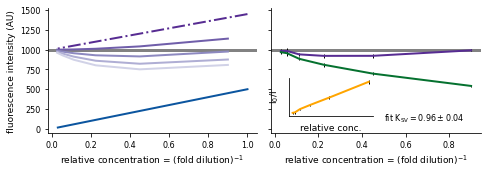

In [20]:
fig, axs = plt.subplots(figsize=(6.875, 2.5), ncols=2, sharey=True)

plt.sca(axs[0])
# Diagram for SI figure 1. 
# Assume that neat supe has a fluorescence of 500 units
fold_dilutions = np.power(2, np.arange(6))
rel_concs = 1/fold_dilutions
fluor_per_conc_sup = 500
supe_fluorescence = fluor_per_conc_sup*rel_concs
plt.plot(rel_concs, supe_fluorescence, color=blues[0])

# While the sensor in buffer has a fluorescence of 1000 units
fluor_sensor_alone = 1000
plt.axhline(fluor_sensor_alone, color=greys[-3], lw=3)

# Null expectation is that they sum with 10% dilution of the supe fluorescence.
expected_fluor_noninteracting = fluor_sensor_alone + 0.9*fluor_per_conc_sup*rel_concs
plt.plot(rel_concs, expected_fluor_noninteracting, color=purples[0], ls='-.')

# Now we consider various different KSV values
for i, ksv in enumerate(np.arange(0.5, 2.1, 0.5)):
    # I0 is the unquenched intensity (fluor_sensor_alone)
    # I0/I = 1 + KSV[Q] where Q is rel_concs*0.9
    # I = I0 / (1+KSV[Q])
    
    qs = 0.9*rel_concs
    quenched_intensity = fluor_sensor_alone / (1+ksv*qs)
    
    # what we actually measrue is the sum of this quenched intensity 
    # and the fluorescence of the supernatant
    plt.plot(qs, quenched_intensity+(0.9*supe_fluorescence),
             color=purples[1+i])

plt.xlabel('relative concentration = (fold dilution)$^{-1}$')
plt.ylabel('fluorescence intensity (AU)')

plt.sca(axs[1])

# Assume KSV = 1, we would measure
qs = 0.9*rel_concs
ksv = 1
quenched_intensity = fluor_sensor_alone / (1+ksv*qs)
measured_intensity = quenched_intensity+(0.9*supe_fluorescence)

# simulate quadruplicate measurement with 3% error
# here % error is as a fraction of the intensity of the sensor alone in buffer
# since the total fluorescence doesn't change much as a function of [Q]. 
meas_shape = (4, measured_intensity.size)
measured_intensity_reps = np.multiply(np.ones(meas_shape), measured_intensity)
measured_intensity_reps +=  np.random.normal(scale=0.03*fluor_sensor_alone, size=meas_shape)
mean_measured_intensity = measured_intensity_reps.mean(axis=0)
std_measured_intensity = measured_intensity_reps.std(axis=0)

plt.axhline(fluor_sensor_alone, color=greys[-3], lw=3)
plt.errorbar(qs, mean_measured_intensity, yerr=std_measured_intensity, 
             color=purples[0], ecolor='k', elinewidth=1)

inferred_I = (measured_intensity_reps - supe_fluorescence*0.9)
mean_inferred_I = inferred_I.mean(axis=0)
std_inferred_I = inferred_I.std(axis=0)
plt.errorbar(qs, mean_inferred_I, yerr=std_inferred_I,
             color=greens[0], ecolor='k', elinewidth=1)
plt.xlabel('relative concentration = (fold dilution)$^{-1}$')

# Inset
ax_ins = inset_axes(axs[1], width="40%", height="30%", loc=3, borderpad=2.5)

I0_over_I_reps = np.divide(fluor_sensor_alone, inferred_I)
ax_ins.errorbar(qs, I0_over_I_reps.mean(axis=0), yerr=I0_over_I_reps.std(axis=0),
                color='orange', ecolor='k', elinewidth=1)

# Fit to S-V model to get KSV. 
# Fitting all the simulated observations to get one slope. 
X1 = qs.tolist()*4
Y = (I0_over_I_reps - 1).flatten()
res1 = sm.OLS(Y, X1).fit()
ksv = res1.params[0]
CIs = res1.conf_int()
ksv_err = ksv - CIs[0, 0]

ksv_txt = 'fit $K_{{SV}} = {0:.2f} \pm {1:.2f}$'.format(ksv, ksv_err)
axs[1].text(0.5, 100, ksv_txt, fontsize=8)

ax_ins.set_ylabel('$I_0/I$')
ax_ins.set_xlabel('relative conc.')
ax_ins.set_xticks([])
ax_ins.set_yticks([])

sns.despine()
plt.tight_layout()
plt.savefig('../figures/figS1_fitting_procedure.png', dpi=600, facecolor='w')
plt.show()